# Median House Value as a Logistic Regression Problem with Mini-batch

### Tensorflow 2

## 1. Import libraries

In [ ]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## 2. Load data

In [ ]:
ATT_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/Colab Notebooks/datasets/Housing/MedianHouseValue/MedianHouseValueOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
#n_final_test = n_instances-n_train-n_dev

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

# We cannot employ the final test examples yet, since this is not the final neural approach.  

x_train: (16342, 9)
t_train: (16342, 3)
x_dev: (2043, 9)
t_dev: (2043, 3)


## 3. Initialize variables

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [ ]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [ ]:
t_train[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [ ]:
t_dev[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
x_train = tf.cast(x_train,tf.float32)
t_train = tf.cast(t_train,tf.float32)
x_dev = tf.cast(x_dev,tf.float32)
t_dev = tf.cast(t_dev,tf.float32)

## 4. Set hyperparameters

We must adjust a new hiperparameter: the size of the mini-batch

In [ ]:
n_iterations = 20000  # 20000 iteraciones / 80 = 250 epochs # AHORA NO SON EPOCAS SI NO Nº DE ITERACIONES
learning_rate = 0.1
batch_size = 200 # Tamaño del batch. En muchos sitios dicen que interesan tamaños de minibatch potencia de 2, por los ordenadores, pero no está demostrado, el profe no crea que sea real porque eso se multiplica por 9 en el flujo del propio ordenador

# 5. Build the neural model: logistic classifier

In [ ]:
W = tf.Variable (tf.random.uniform ([INPUTS,OUTPUTS],-1,1), name="W")
b = tf.Variable (tf.zeros([OUTPUTS]), name = "bias")

Compute the $logits$ (net), then the output with the $Softmax$ activation function:

In [ ]:
def predict (X):
  return tf.nn.softmax (logits=net(X), name="y")

def net (X):
  return tf.add (tf.matmul(X,W), b, name="net")

The *log-loss*, *cross-entropy* $\mathcal{L}$ (the sun of log-loss is a loss) and and *cost* $J$ (the mean of cross-entropy) functions: $J(W) = \frac{1}{m}\sum_{p=1}^{m}\mathcal{L}^{(p)}(y,t)$, where $\mathcal{L}^{(p)}(y,t)=-\sum_{i=1}^{n_y}t_i\log (y_i).$

In [ ]:
def mean_log_loss (n,t):
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits (labels=t, logits=n)
  return tf.reduce_mean (cross_entropy, name="cost")

The training algorithm is the gradient descent method with the *softmax* function in the output neurons

In [ ]:
def training_op(x, t, alpha_lr):
        #First the we compute the error 
        with tf.GradientTape(persistent=True) as g: #persistent=True so parameters can change more than once
            error = mean_log_loss(net(x),t)

        #Then, the partial derivative of the error function regarding the weights; i.e., the parameters W and b    
        dE_dW = g.gradient(error, W)
        dE_db = g.gradient(error, b)
        
        #Finally, we multiply the partial derivative by the learning rate and apply the increment 
        W.assign_sub(alpha_lr * dE_dW)
        b.assign_sub(alpha_lr * dE_db)

        return error

Model evaluation: accuracy. The percentage of correctly classified instances.

In [ ]:
def correct_predictions (y,t):
  return tf.equal(tf.argmax(y,1),tf.argmax(t,1))

def accuracy (y,t):
  return tf.reduce_mean(tf.cast(correct_predictions(y,t),tf.float32))

## 6. Execute the model M-BGD

In [ ]:
# AQUÍ EJECUTAREMOS ITERACIONES EN VEZ DE EPOCAS
accuracy_train_history = np.empty([n_iterations])
error_train_history = np.empty([n_iterations])
for iteration in tqdm(range(n_iterations)): # Ejecutamos ahora iteraciones 
  offset = (iteration * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size) # Desplazamiento
  error = training_op (x_train[offset:(offset+batch_size)], # Va batch a batch. # Cuando ejecutamos la derivada no le pasamos el training set entero
                       t_train[offset:(offset+batch_size)], learning_rate) # Le damos el conjunto de tamaño batch de las entradas y las salidas deseadas
  accuracy_train_history[iteration] = accuracy (predict(x_train[offset:(offset+batch_size)]), 
                                                        t_train[offset:(offset+batch_size)])
  error_train_history[iteration] = error
    
# Tarda menos como se puede ver con resultados similares 

100%|██████████| 20000/20000 [01:07<00:00, 296.64it/s]


## 7. Get the results

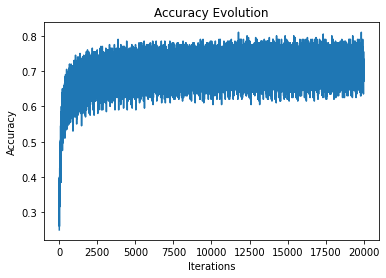

In [ ]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Iterations")
plt.ylabel ("Accuracy")
plt.plot (range(n_iterations),accuracy_train_history)

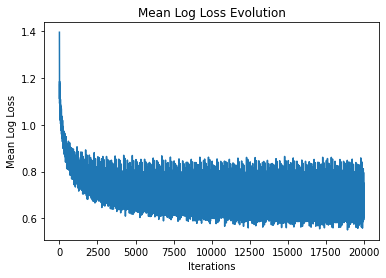

In [ ]:
plt.title ("Mean Log Loss Evolution")
plt.xlabel ("Iterations")
plt.ylabel ("Mean Log Loss")
plt.plot (range(n_iterations),error_train_history)

Note that $zig$-$zags$ are due to mini-batch $zig$-$zagging$ errors. 

In [ ]:
final_accuracy_train = accuracy (predict(x_train),t_train)
final_accuracy_dev = accuracy (predict(x_dev),t_dev)
final_train_mean_log_loss = mean_log_loss(net(x_train),t_train)
final_dev_mean_log_loss = mean_log_loss(net(x_dev),t_dev)

print ("Final Accuracy in training: "+str(final_accuracy_train.numpy()))
print ("Final Accuracy for the development test set: "+str(final_accuracy_dev.numpy()))
print ("Final training mean-log-loss in training: "+str(final_train_mean_log_loss.numpy()))
print ("Final mean-log-loss for the development test set: "+str(final_dev_mean_log_loss.numpy()))

# Accuracy in training: 70% de entrenamiento 
# Y prácticamente lo mismo para desarrollo 

Final Accuracy in training: 0.7053604
Final Accuracy for the development test set: 0.7072932
Final training mean-log-loss in training: 0.6748947
Final mean-log-loss for the development test set: 0.64899725


In [ ]:
predictions = predict(x_dev)
predictions[:20].numpy()

array([[3.0207905e-01, 5.6190413e-01, 1.3601682e-01],
       [8.6614424e-03, 1.2306381e-01, 8.6827475e-01],
       [8.3271819e-01, 1.6423462e-01, 3.0472637e-03],
       [2.0944068e-02, 4.1464368e-01, 5.6441218e-01],
       [7.9367739e-01, 1.9176538e-01, 1.4557227e-02],
       [5.7144657e-02, 5.5280608e-01, 3.9004931e-01],
       [1.6176239e-02, 4.0911016e-01, 5.7471359e-01],
       [1.2768910e-03, 1.1019058e-01, 8.8853252e-01],
       [4.1066109e-08, 5.4470939e-04, 9.9945527e-01],
       [5.3554827e-01, 4.0779570e-01, 5.6656044e-02],
       [1.7457981e-01, 6.5204924e-01, 1.7337099e-01],
       [4.2981005e-01, 4.6780270e-01, 1.0238733e-01],
       [4.8141798e-01, 4.3767595e-01, 8.0906048e-02],
       [3.4934905e-01, 4.5605946e-01, 1.9459152e-01],
       [9.9402535e-01, 5.9664333e-03, 8.1910475e-06],
       [3.0294770e-02, 2.0089613e-01, 7.6880908e-01],
       [8.2444239e-01, 1.6416708e-01, 1.1390484e-02],
       [1.1641766e-03, 1.4465749e-01, 8.5417837e-01],
       [1.2973650e-01, 5.836

In [ ]:
rounded_predictions=np.round(predictions)
indices = np.argmax(predictions,1)
for row, index in zip(rounded_predictions, indices): row[index]=1
rounded_predictions[:20]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
t_dev[:20].numpy()

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
dev_predictions = correct_predictions(predict(x_dev),t_dev).numpy()
dev_predictions[:20]

array([False,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True])

In [ ]:
from collections import Counter
Counter(dev_predictions)
# Vemos que hay 598 fallos y 1445 aciertos

Counter({False: 598, True: 1445})

<b>MBGD employs less epochs than BGD to achieve similar results</b> for the same task. TPU runtime type has been employed.  


Conclusión: El mini-batch gradient descendent emplea menos épocas y alcanza resultados similares para la misma tarea